
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [9]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, nextQs

In [10]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [11]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [12]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, next_states, nextQs, # model data
               state_size, action_size, hidden_size): # model init
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states, 
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size)
    
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, nextnext_states_logits = generator(prev_actions=actions_onehot, states=next_states,
                                                            hidden_size=hidden_size, state_size=state_size, 
                                                            action_size=action_size, reuse=True)
    # Masking actions_logits unmasked
    Qs_masked = tf.multiply(actions_logits, actions_onehot)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # nextQs
    nextQs = tf.reshape(nextQs, [-1, 1])
    Qs = tf.reshape(Qs, [-1, 1])

    # Discriminator for nextQs_real and nextQs_fake
    nextQs_fake = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                hidden_size=hidden_size)
    nextQs_real = discriminator(prev_actions=next_actions_logits, states=nextnext_states_logits, 
                                hidden_size=hidden_size, reuse=True)

    # Generator loss
    #g_loss = tf.reduce_mean(tf.square(Qs - nextQs))
    g_loss_fake1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                          labels=tf.nn.sigmoid(nextQs)))
    g_loss_fake2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
                                                                          labels=tf.nn.sigmoid(nextQs)))
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.zeros_like(nextQs)))
    g_loss = g_loss_fake1 + g_loss_fake2 + g_loss_real

    # Discriminator loss
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake, 
                                                                         labels=tf.zeros_like(nextQs)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real, 
                                                                         labels=tf.nn.sigmoid(nextQs)))
    d_loss = d_loss_fake + d_loss_real

    return actions_logits, g_loss, d_loss

In [13]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [14]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.nextQs = model_input(
            state_size=state_size)

        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.g_loss, self.d_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init parameters
            prev_actions=self.prev_actions, states=self.states, 
            actions=self.actions, next_states=self.next_states,
            nextQs=self.nextQs) # model input data
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss,
                                           d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [15]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [17]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 2000              # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [18]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [19]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [20]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.nextQs: nextQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 13 Training g_loss: 1.8798 Training d_loss: 1.1811 Explore P: 0.9987
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 13 Training g_loss: 1.7049 Training d_loss: 1.0199 Explore P: 0.9974
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 22 Training g_loss: 1.7123 Training d_loss: 1.0227 Explore P: 0.9953
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 30 Training g_loss: 1.7022 Training d_loss: 1.0126 Explore P: 0.9923
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 59 Training g_loss: 1.9045 Training d_loss: 1.2512 Explore P: 0.9336
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 24 Training g_loss: 1.9058 Training d_loss: 1.2543 Explore P: 0.9314
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 13 Training g_loss: 1.9065 Training d_loss: 1.2558 Explore P: 0.9302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 11 Training g_loss: 1.9065 Training d_loss: 1.2546 Explore P: 0.9292
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 20 Training g_loss: 1.8796 Training d_loss: 1.1965 Explore P: 0.8804
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 9 Training g_loss: 1.8795 Training d_loss: 1.1963 Explore P: 0.8796
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 10 Training g_loss: 1.8812 Training d_loss: 1.1987 Explore P: 0.8787
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 15 Training g_loss: 1.8847 Training d_loss: 1.2042 Explore P: 0.8774
-------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 99 Total reward: 24 Training g_loss: 1.7872 Training d_loss: 1.3528 Explore P: 0.8155
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 100 Total reward: 35 Training g_loss: 1.6385 Training d_loss: 1.3860 Explore P: 0.8126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 55 Training g_loss: 1.5822 Training d_loss: 1.3775 Explore P: 0.8082
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 23 Training g_loss: 1.6718 Training d_loss: 1.3501 Explore P: 0.8064
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 132 Total reward: 28 Training g_loss: 1.5467 Training d_loss: 1.3712 Explore P: 0.7515
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 133 Total reward: 9 Training g_loss: 1.5308 Training d_loss: 1.3820 Explore P: 0.7509
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 21 Training g_loss: 1.6491 Training d_loss: 1.3550 Explore P: 0.7493
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 15 Training g_loss: 1.6332 Training d_loss: 1.3716 Explore P: 0.7482
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 165 Total reward: 57 Training g_loss: 1.6277 Training d_loss: 1.3834 Explore P: 0.6908
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 166 Total reward: 19 Training g_loss: 1.6170 Training d_loss: 1.3814 Explore P: 0.6895
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 27 Training g_loss: 1.6297 Training d_loss: 1.3796 Explore P: 0.6876
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 21 Training g_loss: 1.6561 Training d_loss: 1.3770 Explore P: 0.6862
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 198 Total reward: 14 Training g_loss: 1.8843 Training d_loss: 1.3195 Explore P: 0.6245
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 199 Total reward: 13 Training g_loss: 1.8897 Training d_loss: 1.3185 Explore P: 0.6237
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 13 Training g_loss: 1.8463 Training d_loss: 1.3435 Explore P: 0.6229
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 9 Training g_loss: 1.8291 Training d_loss: 1.3504 Explore P: 0.6224
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 231 Total reward: 31 Training g_loss: 1.8104 Training d_loss: 1.3497 Explore P: 0.5700
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 74 Training g_loss: 1.7827 Training d_loss: 1.3550 Explore P: 0.5659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 94 Training g_loss: 1.6835 Training d_loss: 1.3734 Explore P: 0.5607
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 25 Training g_loss: 1.6891 Training d_loss: 1.3692 Explore P: 0.5593
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 263 Total reward: 15 Training g_loss: 0.7711 Training d_loss: 0.0678 Explore P: 0.4879
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 264 Total reward: 13 Training g_loss: 0.7703 Training d_loss: 0.0649 Explore P: 0.4872
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 265 Total reward: 11 Training g_loss: 0.7725 Training d_loss: 0.0638 Explore P: 0.4867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 266 Total reward: 9 Training g_loss: 0.7578 Training d_loss: 0.0533 Explore P: 0.4863
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 296 Total reward: 28 Training g_loss: 1.5323 Training d_loss: 1.3738 Explore P: 0.4646
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 297 Total reward: 22 Training g_loss: 1.5079 Training d_loss: 1.3644 Explore P: 0.4636
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 298 Total reward: 23 Training g_loss: 1.5028 Training d_loss: 1.3681 Explore P: 0.4626
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 299 Total reward: 61 Training g_loss: 1.5384 Training d_loss: 1.3506 Explore P: 0.4598
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 329 Total reward: 59 Training g_loss: 1.4716 Training d_loss: 1.3532 Explore P: 0.4008
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 330 Total reward: 47 Training g_loss: 1.4963 Training d_loss: 1.3523 Explore P: 0.3989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 331 Total reward: 34 Training g_loss: 1.4771 Training d_loss: 1.3338 Explore P: 0.3976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 332 Total reward: 27 Training g_loss: 1.4676 Training d_loss: 1.3050 Explore P: 0.3966
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 362 Total reward: 13 Training g_loss: 0.7719 Training d_loss: 0.0714 Explore P: 0.3491
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 363 Total reward: 14 Training g_loss: 0.7665 Training d_loss: 0.0664 Explore P: 0.3487
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 364 Total reward: 13 Training g_loss: 0.7650 Training d_loss: 0.0642 Explore P: 0.3482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 365 Total reward: 15 Training g_loss: 0.7708 Training d_loss: 0.0713 Explore P: 0.3477
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 395 Total reward: 12 Training g_loss: 0.7576 Training d_loss: 0.0481 Explore P: 0.3361
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 396 Total reward: 13 Training g_loss: 0.7562 Training d_loss: 0.0463 Explore P: 0.3357
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 397 Total reward: 10 Training g_loss: 0.7563 Training d_loss: 0.0457 Explore P: 0.3354
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 398 Total reward: 13 Training g_loss: 0.7555 Training d_loss: 0.0459 Explore P: 0.3349
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 427 Total reward: 79 Training g_loss: 1.4704 Training d_loss: 1.3097 Explore P: 0.2724
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 428 Total reward: 71 Training g_loss: 1.4967 Training d_loss: 1.3393 Explore P: 0.2705
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 429 Total reward: 66 Training g_loss: 1.4774 Training d_loss: 1.3416 Explore P: 0.2688
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 430 Total reward: 184 Training g_loss: 1.4616 Training d_loss: 1.3631 Explore P: 0.2641
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 459 Total reward: 164 Training g_loss: 1.2076 Training d_loss: 0.7033 Explore P: 0.2048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 460 Total reward: 129 Training g_loss: 1.1975 Training d_loss: 0.6057 Explore P: 0.2023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 461 Total reward: 125 Training g_loss: 0.7503 Training d_loss: 0.0446 Explore P: 0.1999
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 462 Total reward: 107 Training g_loss: 0.7611 Training d_loss: 0.0543 Explore P: 0.1979
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 491 Total reward: 126 Training g_loss: 1.4697 Training d_loss: 1.3398 Explore P: 0.1460
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 492 Total reward: 139 Training g_loss: 1.3976 Training d_loss: 1.2491 Explore P: 0.1441
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 493 Total reward: 108 Training g_loss: 0.7485 Training d_loss: 0.0522 Explore P: 0.1427
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 494 Total reward: 35 Training g_loss: 0.7560 Training d_loss: 0.0584 Explore P: 0.1422
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 523 Total reward: 11 Training g_loss: 0.7590 Training d_loss: 0.0627 Explore P: 0.1190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 524 Total reward: 10 Training g_loss: 0.7593 Training d_loss: 0.0564 Explore P: 0.1189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 525 Total reward: 12 Training g_loss: 0.7491 Training d_loss: 0.0535 Explore P: 0.1187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 526 Total reward: 19 Training g_loss: 0.7486 Training d_loss: 0.0382 Explore P: 0.1185
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 556 Total reward: 28 Training g_loss: 1.4878 Training d_loss: 1.2689 Explore P: 0.1054
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 557 Total reward: 9 Training g_loss: 1.4731 Training d_loss: 1.2254 Explore P: 0.1053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 558 Total reward: 127 Training g_loss: 1.3575 Training d_loss: 0.9971 Explore P: 0.1041
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 559 Total reward: 199 Training g_loss: 1.2544 Training d_loss: 0.8732 Explore P: 0.1022
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 588 Total reward: 49 Training g_loss: 1.2853 Training d_loss: 1.0222 Explore P: 0.0800
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 589 Total reward: 44 Training g_loss: 1.2965 Training d_loss: 1.0577 Explore P: 0.0797
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 590 Total reward: 45 Training g_loss: 1.3166 Training d_loss: 1.0936 Explore P: 0.0794
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 591 Total reward: 49 Training g_loss: 1.2951 Training d_loss: 1.0641 Explore P: 0.0791
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 620 Total reward: 33 Training g_loss: 1.4403 Training d_loss: 1.3542 Explore P: 0.0642
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 621 Total reward: 40 Training g_loss: 1.3983 Training d_loss: 1.1987 Explore P: 0.0640
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 622 Total reward: 62 Training g_loss: 1.3475 Training d_loss: 1.1220 Explore P: 0.0637
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 623 Total reward: 48 Training g_loss: 1.2360 Training d_loss: 0.8978 Explore P: 0.0634
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 653 Total reward: 26 Training g_loss: 1.6468 Training d_loss: 1.4195 Explore P: 0.0552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 654 Total reward: 9 Training g_loss: 1.6322 Training d_loss: 1.4362 Explore P: 0.0552
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 655 Total reward: 9 Training g_loss: 1.4829 Training d_loss: 1.3991 Explore P: 0.0551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 656 Total reward: 199 Training g_loss: 1.3335 Training d_loss: 1.0898 Explore P: 0.0542
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 686 Total reward: 12 Training g_loss: 0.7376 Training d_loss: 0.0401 Explore P: 0.0500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 687 Total reward: 11 Training g_loss: 0.7573 Training d_loss: 0.0544 Explore P: 0.0500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 688 Total reward: 8 Training g_loss: 0.7654 Training d_loss: 0.0650 Explore P: 0.0499
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 689 Total reward: 11 Training g_loss: 0.7891 Training d_loss: 0.0923 Explore P: 0.0499
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 718 Total reward: 41 Training g_loss: 1.5433 Training d_loss: 1.4373 Explore P: 0.0392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 719 Total reward: 11 Training g_loss: 1.5355 Training d_loss: 1.4253 Explore P: 0.0391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 720 Total reward: 9 Training g_loss: 1.4793 Training d_loss: 1.3899 Explore P: 0.0391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 721 Total reward: 11 Training g_loss: 1.4591 Training d_loss: 1.3939 Explore P: 0.0391
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 750 Total reward: 199 Training g_loss: 0.8492 Training d_loss: 0.1456 Explore P: 0.0330
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 751 Total reward: 59 Training g_loss: 0.7437 Training d_loss: 0.0440 Explore P: 0.0328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 752 Total reward: 22 Training g_loss: 0.7375 Training d_loss: 0.0380 Explore P: 0.0328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 753 Total reward: 13 Training g_loss: 0.7483 Training d_loss: 0.0460 Explore P: 0.0327
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 783 Total reward: 124 Training g_loss: 0.7412 Training d_loss: 0.0431 Explore P: 0.0311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 784 Total reward: 86 Training g_loss: 1.5864 Training d_loss: 1.4099 Explore P: 0.0309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 785 Total reward: 9 Training g_loss: 1.5089 Training d_loss: 1.4067 Explore P: 0.0309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 10 Training g_loss: 1.4845 Training d_loss: 1.3870 Explore P: 0.0309
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 816 Total reward: 11 Training g_loss: 0.7576 Training d_loss: 0.0565 Explore P: 0.0291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 817 Total reward: 9 Training g_loss: 0.7570 Training d_loss: 0.0577 Explore P: 0.0290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 818 Total reward: 8 Training g_loss: 0.7480 Training d_loss: 0.0504 Explore P: 0.0290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 819 Total reward: 10 Training g_loss: 0.7510 Training d_loss: 0.0547 Explore P: 0.0290
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 849 Total reward: 8 Training g_loss: 0.7397 Training d_loss: 0.0388 Explore P: 0.0266
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 850 Total reward: 12 Training g_loss: 0.7428 Training d_loss: 0.0396 Explore P: 0.0266
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 851 Total reward: 10 Training g_loss: 0.7319 Training d_loss: 0.0291 Explore P: 0.0265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 852 Total reward: 11 Training g_loss: 0.7388 Training d_loss: 0.0367 Explore P: 0.0265
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 882 Total reward: 8 Training g_loss: 0.7334 Training d_loss: 0.0337 Explore P: 0.0260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 883 Total reward: 11 Training g_loss: 0.7319 Training d_loss: 0.0283 Explore P: 0.0260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 884 Total reward: 8 Training g_loss: 0.7398 Training d_loss: 0.0374 Explore P: 0.0260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 885 Total reward: 11 Training g_loss: 0.7324 Training d_loss: 0.0299 Explore P: 0.0260
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 915 Total reward: 11 Training g_loss: 0.7363 Training d_loss: 0.0317 Explore P: 0.0256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 916 Total reward: 9 Training g_loss: 0.7416 Training d_loss: 0.0369 Explore P: 0.0255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 917 Total reward: 12 Training g_loss: 0.7469 Training d_loss: 0.0391 Explore P: 0.0255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 918 Total reward: 10 Training g_loss: 0.7418 Training d_loss: 0.0374 Explore P: 0.0255
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 948 Total reward: 32 Training g_loss: 1.4530 Training d_loss: 1.3514 Explore P: 0.0244
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 949 Total reward: 100 Training g_loss: 1.4426 Training d_loss: 1.3563 Explore P: 0.0243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 950 Total reward: 88 Training g_loss: 1.4424 Training d_loss: 1.3425 Explore P: 0.0241
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 951 Total reward: 105 Training g_loss: 1.4402 Training d_loss: 1.3516 Explore P: 0.0240
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 980 Total reward: 9 Training g_loss: 0.7736 Training d_loss: 0.0750 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 981 Total reward: 10 Training g_loss: 0.7779 Training d_loss: 0.0804 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 982 Total reward: 7 Training g_loss: 0.7620 Training d_loss: 0.0642 Explore P: 0.0212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 983 Total reward: 7 Training g_loss: 0.7676 Training d_loss: 0.0595 Explore P: 0.0212
-----------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

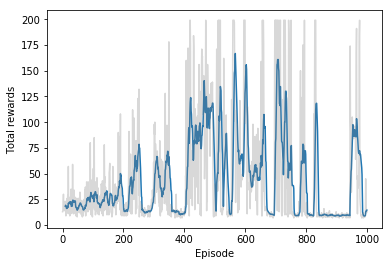

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

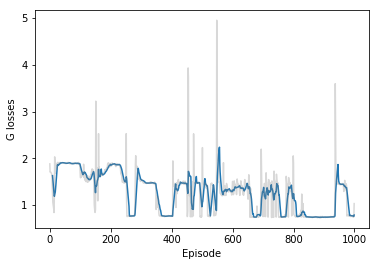

In [23]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

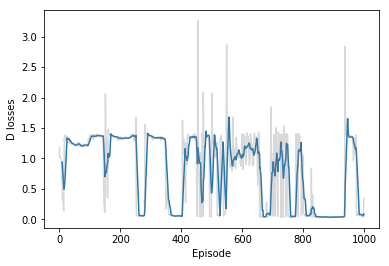

In [24]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.